In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
import nanonets
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from scipy.optimize import curve_fit
from scipy.special import gamma
plt.style.use(["science","bright","grid"])

cm  = plt.get_cmap('cividis')
ma  = ["o","s","^","v","<",">"]

## DC Input - Voltage Distribution - Closed Circuit

In [16]:
def shift_and_append(dfs_dict):
    for name, df in dfs_dict.items():
        col1 = df.pop("1")  # remove column 1
        df.columns = range(df.shape[1])  # reassign column names to keep them sequential
        df[len(df.columns)] = col1  # append column 1's data at the end
    return dfs_dict

folder1     = "/home/j/j_mens07/phd/data/2_funding_period/current/wo_magic_cable/dc_input_vs_volt/"
folder2     = "/home/j/j_mens07/phd/data/2_funding_period/potential/wo_magic_cable/dc_input_vs_volt/"
U0_vals     = [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1]
N_p         = 10

N_voltages      = 50000
t_vals          = np.arange(N_voltages-1)*1e-10*1e9
pot_closed      = {U_0 : pd.read_csv(f"{folder1}mean_state_Nx={N_p}_Ny=1_Ne=2_{U_0:.3f}.csv").round(5) for U_0 in U0_vals}
pot_closed      = shift_and_append(pot_closed)
pot_eq_closed   = pd.DataFrame([pot_closed[U_0].iloc[48000:,:].mean().values / U_0 for U_0 in U0_vals],index=U0_vals).T.round(2)
pot_open        = {U_0 : pd.read_csv(f"{folder2}mean_state_Nx={N_p}_Ny=1_Ne=2_{U_0:.3f}.csv").round(5) for U_0 in U0_vals}
pot_open        = shift_and_append(pot_open)
pot_eq_open     = pd.DataFrame([pot_open[U_0].iloc[48000:,:].mean().values / U_0 for U_0 in U0_vals],index=U0_vals).T.round(2)

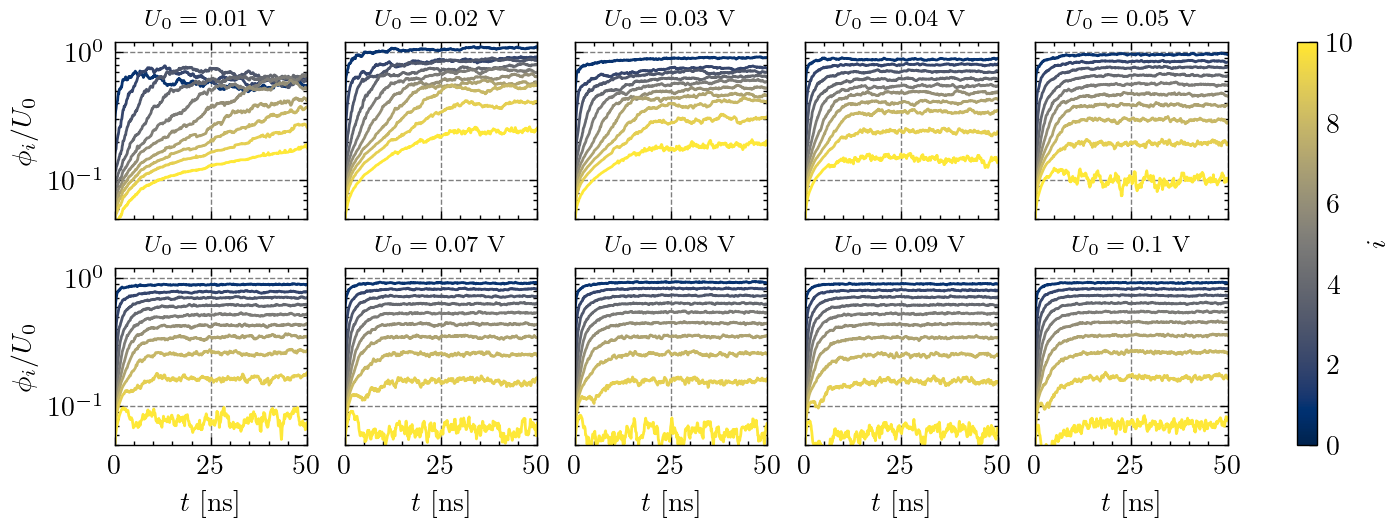

In [17]:
fig     = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)
norm    = Normalize(vmin=0, vmax=10)
all_ax  = []

for n, U_0 in enumerate(U0_vals):
    ax = fig.add_subplot(2,5,n+1)
    all_ax.append(ax)
    for i in range(1,N_p+1):
        ax.plot(t_vals, pot_closed[U_0][i].values/U_0, color=cm(norm(i)))
    ax.set_title(f"$U_0 = {U_0}$ V", fontsize='small')
    ax.set_xlim(0,50)
    ax.set_ylim(0.05,1.2)
    ax.set_yscale('log')
    
    if n % 5 == 0:
        ax.set_ylabel("$\phi_i / U_0$")
    else:
        ax.set_yticklabels("")
    if n >= 5:
        ax.set_xlabel("$t$ [ns]")
    else:
        ax.set_xticklabels("")

sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=all_ax)
cbar.set_label("$i$")

# fig.savefig("../plots/dc_input/linear/closed_circuit_node_time_series.svg", transparent=True)

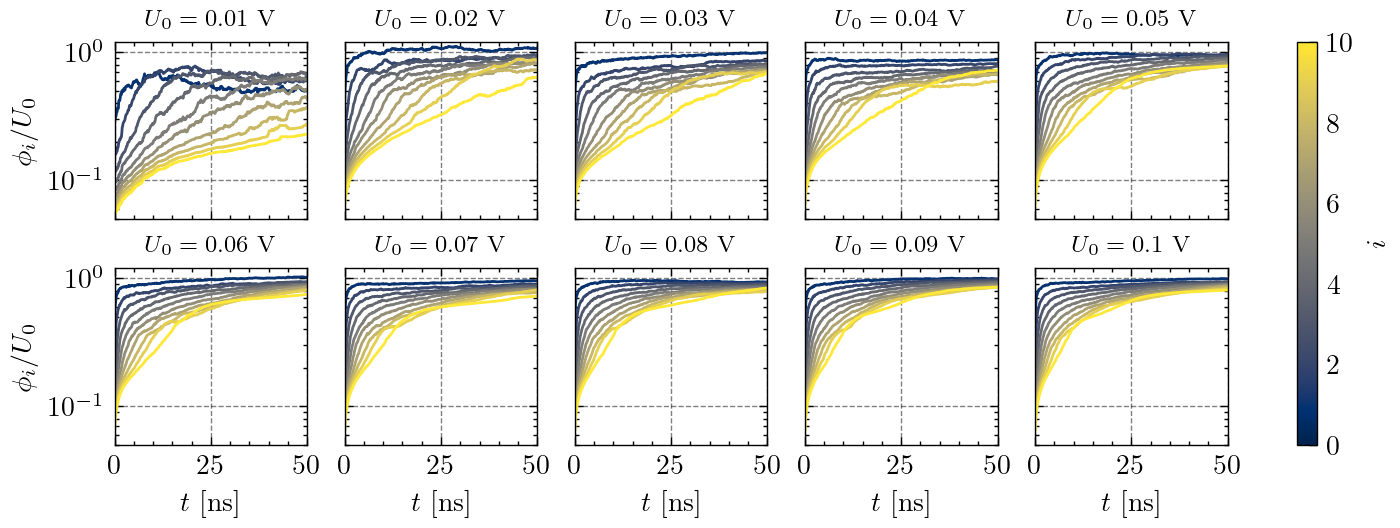

In [18]:
fig     = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)
norm    = Normalize(vmin=0, vmax=10)
all_ax  = []

for n, U_0 in enumerate(U0_vals):
    ax = fig.add_subplot(2,5,n+1)
    all_ax.append(ax)
    for i in range(1,N_p+1):
        ax.plot(t_vals, pot_open[U_0][i].values/U_0, color=cm(norm(i)))
    ax.set_title(f"$U_0 = {U_0}$ V", fontsize='small')
    ax.set_xlim(0,50)
    ax.set_ylim(0.05,1.2)
    ax.set_yscale('log')
    
    if n % 5 == 0:
        ax.set_ylabel("$\phi_i / U_0$")
    else:
        ax.set_yticklabels("")
    if n >= 5:
        ax.set_xlabel("$t$ [ns]")
    else:
        ax.set_xticklabels("")

sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=all_ax)
cbar.set_label("$i$")

# fig.savefig("../plots/dc_input/linear/closed_circuit_node_time_series.svg", transparent=True)

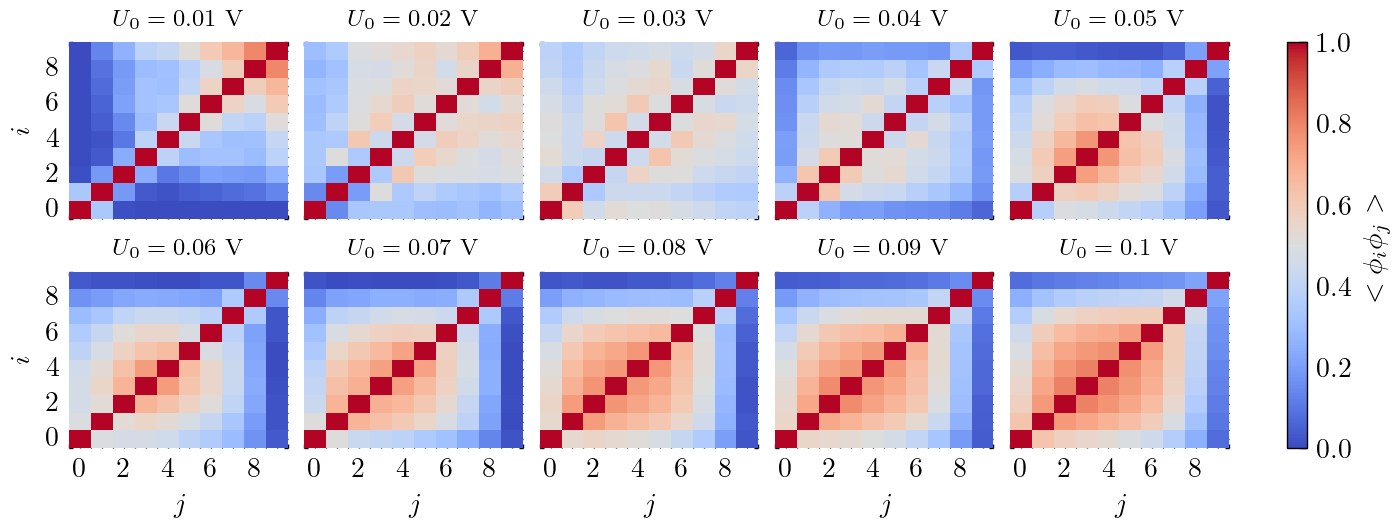

In [19]:
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)
all_ax  = []
norm    = Normalize(vmin=0, vmax=1)

for n, U_0 in enumerate(U0_vals):

    ax = fig.add_subplot(2,5,n+1)
    df = pd.DataFrame(pot_closed[U_0].drop(columns=[0,11]).values)
    ax = sns.heatmap(df.corr(), cmap='coolwarm', vmin=0, vmax=1, cbar=False)
    _  = plt.yticks(rotation=0)
    all_ax.append(ax)

    if n % 5 == 0:
        ax.set_ylabel("$i$")
    else:
        ax.set_yticklabels("")
    if n >= 5:
        ax.set_xlabel("$j$")
    else:
        ax.set_xticklabels("")
        
    ax.set_title(f"$U_0 = {U_0}$ V", fontsize='small')
    ax.invert_yaxis()

sm  = ScalarMappable(cmap='coolwarm', norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=all_ax)
cbar.set_label("$<\phi_{i}\phi_{j}>$")

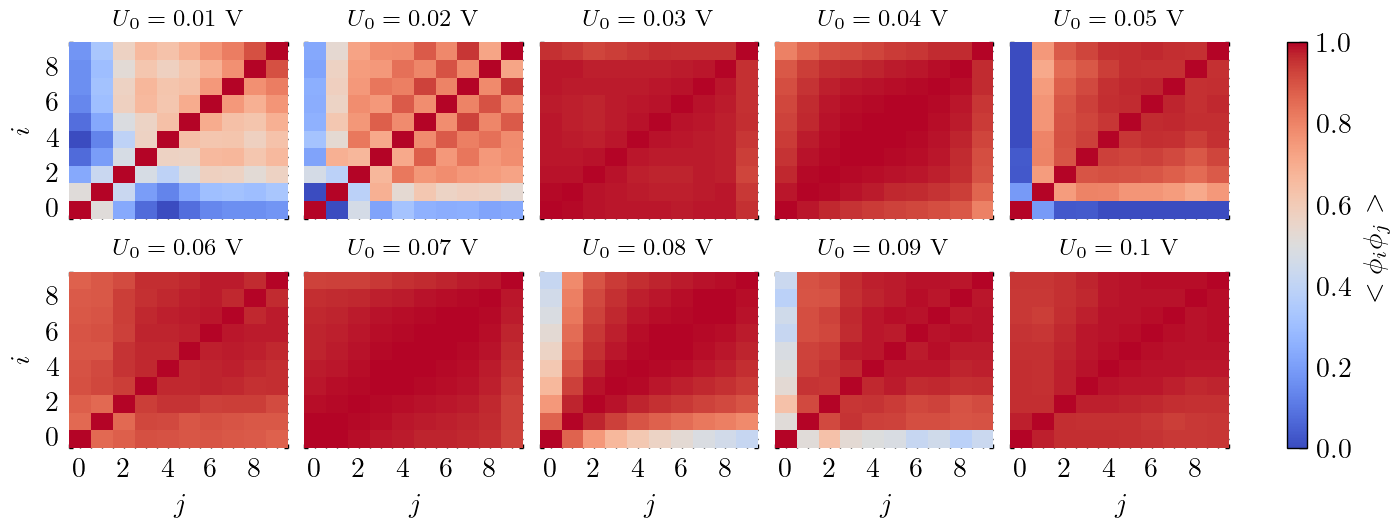

In [20]:
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)
all_ax  = []
norm    = Normalize(vmin=0, vmax=1)

for n, U_0 in enumerate(U0_vals):

    ax = fig.add_subplot(2,5,n+1)
    df = pd.DataFrame(pot_open[U_0].drop(columns=[0,11]).values)
    ax = sns.heatmap(df.corr(), cmap='coolwarm', vmin=0, vmax=1, cbar=False)
    _  = plt.yticks(rotation=0)
    all_ax.append(ax)

    if n % 5 == 0:
        ax.set_ylabel("$i$")
    else:
        ax.set_yticklabels("")
    if n >= 5:
        ax.set_xlabel("$j$")
    else:
        ax.set_xticklabels("")
        
    ax.set_title(f"$U_0 = {U_0}$ V", fontsize='small')
    ax.invert_yaxis()

sm  = ScalarMappable(cmap='coolwarm', norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=all_ax)
cbar.set_label("$<\phi_{i}\phi_{j}>$")

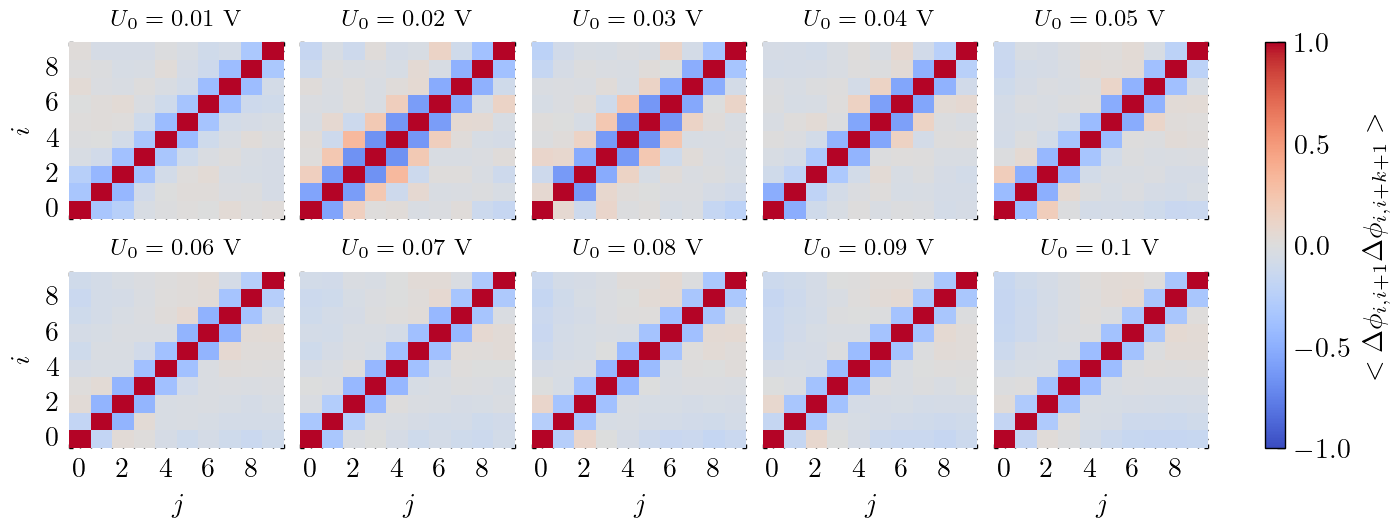

In [21]:
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)
all_ax  = []
norm    = Normalize(vmin=-1, vmax=1)

for n, U_0 in enumerate(U0_vals):

    ax = fig.add_subplot(2,5,n+1)
    df = pd.DataFrame(pot_closed[U_0].diff(axis=1).drop(columns=[0,11]).values)
    ax = sns.heatmap(df.corr(), cmap='coolwarm', vmin=-1, vmax=1, cbar=False)
    _  = plt.yticks(rotation=0)
    all_ax.append(ax)

    if n % 5 == 0:
        ax.set_ylabel("$i$")
    else:
        ax.set_yticklabels("")
    if n >= 5:
        ax.set_xlabel("$j$")
    else:
        ax.set_xticklabels("")
        
    ax.set_title(f"$U_0 = {U_0}$ V", fontsize='small')
    ax.invert_yaxis()

sm  = ScalarMappable(cmap='coolwarm', norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=all_ax)
cbar.set_label("$<\Delta\phi_{i,i+1}\Delta\phi_{i,i+k+1}>$")

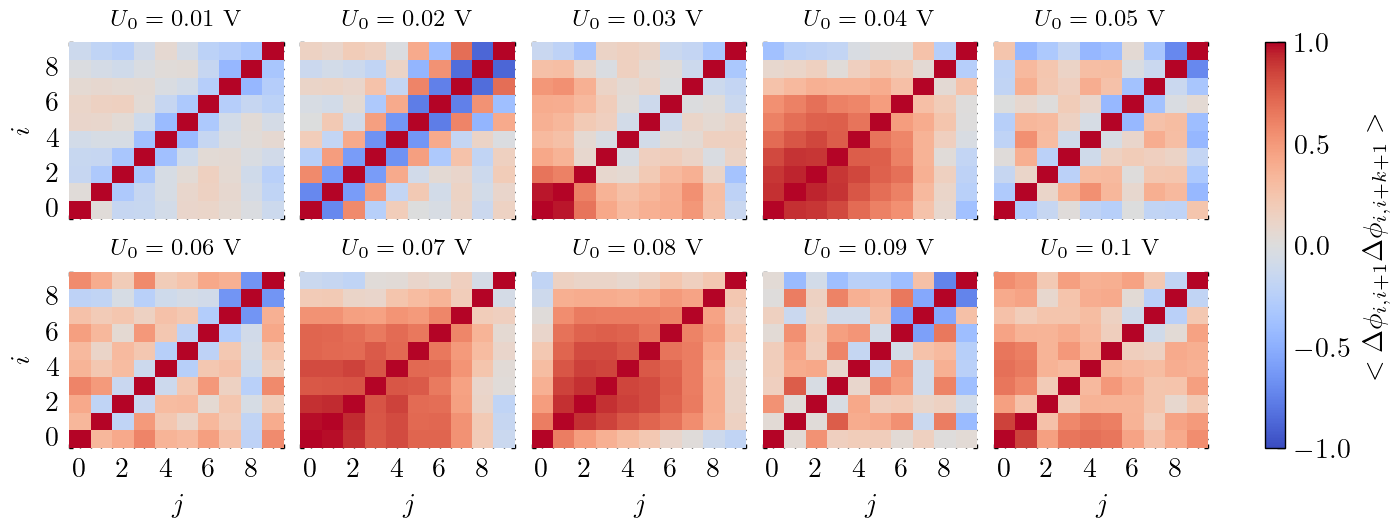

In [22]:
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)
all_ax  = []
norm    = Normalize(vmin=-1, vmax=1)

for n, U_0 in enumerate(U0_vals):

    ax = fig.add_subplot(2,5,n+1)
    df = pd.DataFrame(pot_open[U_0].diff(axis=1).drop(columns=[0,11]).values)
    ax = sns.heatmap(df.corr(), cmap='coolwarm', vmin=-1, vmax=1, cbar=False)
    _  = plt.yticks(rotation=0)
    all_ax.append(ax)

    if n % 5 == 0:
        ax.set_ylabel("$i$")
    else:
        ax.set_yticklabels("")
    if n >= 5:
        ax.set_xlabel("$j$")
    else:
        ax.set_xticklabels("")
        
    ax.set_title(f"$U_0 = {U_0}$ V", fontsize='small')
    ax.invert_yaxis()

sm  = ScalarMappable(cmap='coolwarm', norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=all_ax)
cbar.set_label("$<\Delta\phi_{i,i+1}\Delta\phi_{i,i+k+1}>$")

### Characteristic Time Scale

In [42]:
p_vals_c, cov_vals_c = {}, {}
p0, p1 = 0.9, 0.995
for U_0 in U0_vals:
    p_tmp, cov_tmp = [], []
    for k in range(1, N_p+1):

        x       = t_vals.copy()
        y       = pot_closed[U_0].loc[:,k].values
        y_max   = np.mean(y[-10000:])
        def func(t, tau, a0):
            return y_max - a0*np.exp(-t/tau)
        
        t0      = np.argmax(y>p0*y_max)
        t1      = np.argmax(y>p1*y_max)
        x_fit   = x.copy()[t0:t1]
        y_fit   = y.copy()[t0:t1]
        p, cov  = curve_fit(func, x_fit, y_fit, p0=[20,y_max], bounds=((0,0),(np.inf,np.inf)))

        p_tmp.append(p)
        cov_tmp.append(cov)
    p_vals_c[U_0] = np.array(p_tmp)
    cov_vals_c[U_0] = np.array(cov_tmp)

/tmp/ipykernel_32445/2025687546.py:17: OptimizeWarning: Covariance of the parameters could not be estimated
  p, cov  = curve_fit(func, x_fit, y_fit, p0=[20,y_max], bounds=((0,0),(np.inf,np.inf)))


In [40]:
p_vals_o, cov_vals_o = {}, {}
p0, p1 = 0.9, 0.995
for U_0 in U0_vals:
    p_tmp, cov_tmp = [], []
    for k in range(1, N_p+1):

        x       = t_vals.copy()
        y       = pot_open[U_0].loc[:,k].values
        y_max   = np.mean(y[-10000:])
        def func(t, tau, a0):
            return y_max - a0*np.exp(-t/tau)
        
        t0      = np.argmax(y>p0*y_max)
        t1      = np.argmax(y>p1*y_max)
        x_fit   = x.copy()[t0:t1]
        y_fit   = y.copy()[t0:t1]
        try:
            p, cov  = curve_fit(func, x_fit, y_fit, p0=[20,y_max], bounds=((0,0),(np.inf,np.inf)))
        except:
            p   = np.array([0,0])
            cov = np.array([[0.0,0.0],[0.0,0.0]])
        p_tmp.append(p)
        cov_tmp.append(cov)
    p_vals_o[U_0] = np.array(p_tmp)
    cov_vals_o[U_0] = np.array(cov_tmp)

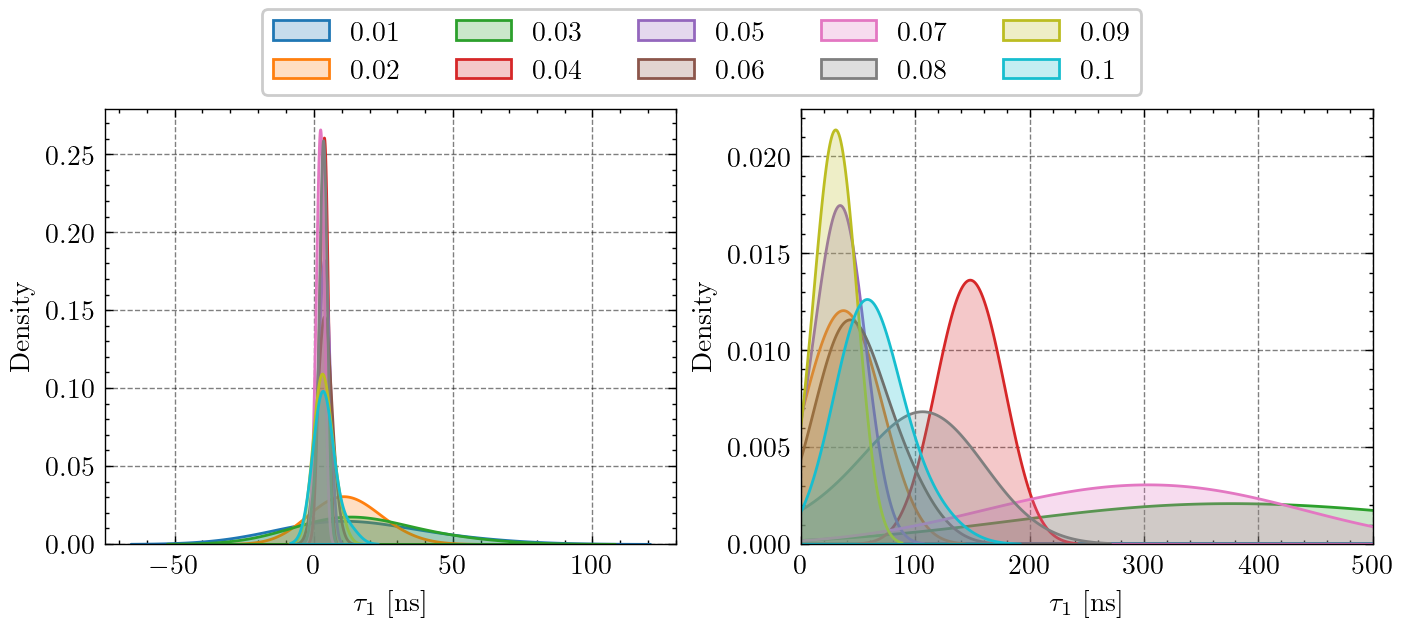

In [62]:
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)
norm = Normalize(vmin=U0_vals[0], vmax=U0_vals[-1])
ax  = fig.add_subplot(1,2,1)
cm2 = plt.get_cmap("tab10")
for U_0 in U0_vals:
    arr = p_vals_c[U_0][:,0].copy()
    ax  = sns.kdeplot(arr, color=cm2(norm(U_0)), fill=True, bw_adjust=2)
    # ax.set_xlim(0,50)
    ax.set_xlabel("$\\tau_1$ [ns]")

ax = fig.add_subplot(1,2,2)
for U_0 in U0_vals:
    arr = p_vals_o[U_0][:,0].copy()
    ax  = sns.kdeplot(arr, color=cm2(norm(U_0)), fill=True, bw_adjust=2)
    ax.set_xlim(0,500)
    ax.set_xlabel("$\\tau_1$ [ns]")

fig.legend(U0_vals, bbox_to_anchor=(0.5, 1.2), ncol=5, loc='upper center', shadow=False)